<a href="https://colab.research.google.com/github/ricardodeazambuja/MaskDetection-EdgeTPU-RPI0/blob/main/EdgeTPU_MaskDetection_Testing_(using_COCO_API).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Testing the FaceMask Detection on edgetpu using mobiledet ssdlite

In [ ]:
# Mount Google Drive:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Datasets

https://makeml.app/datasets/mask has only 853 images

https://www.kaggle.com/ivandanilovich/medical-masks-dataset-images-tfrecords has 1148 (you need to log in to download it, so I have it in my drive)

https://github.com/TheSSJ2612/Real-Time-Medical-Mask-Detection/releases/download/v0.1/Dataset.zip has 5521 images for each category (mask/no-mask), but without annotations

In [ ]:
# Download the Mask Dataset from MakeML: https://makeml.app/datasets/mask
# License: Public Domain Mark
!mkdir /content/dataset
%cd /content/dataset
!wget https://arcraftimages.s3-accelerate.amazonaws.com/Datasets/Mask/MaskPascalVOC.zip
!unzip MaskPascalVOC.zip > /dev/null 2>&1
!rm -r __* # remove MacOS cache

/content/dataset
--2021-05-07 15:33:55--  https://arcraftimages.s3-accelerate.amazonaws.com/Datasets/Mask/MaskPascalVOC.zip
Resolving arcraftimages.s3-accelerate.amazonaws.com (arcraftimages.s3-accelerate.amazonaws.com)... 52.84.161.221
Connecting to arcraftimages.s3-accelerate.amazonaws.com (arcraftimages.s3-accelerate.amazonaws.com)|52.84.161.221|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 417606530 (398M) [application/zip]
Saving to: ‘MaskPascalVOC.zip’

MaskPascalVOC.zip   100%[===================>] 398.26M  69.1MB/s    in 5.9s    

2021-05-07 15:34:01 (67.5 MB/s) - ‘MaskPascalVOC.zip’ saved [417606530/417606530]



In [ ]:
ls /content/dataset

annotations/  images/  MaskPascalVOC.zip


In [ ]:
!rm -rf MaskPascalVOC.zip

In [ ]:
!ls /content/dataset/images | wc -l

853


In [ ]:
!ls /content/dataset/annotations | wc -l

853


In [ ]:
  # Lets create a mask_label_map.pbtxt file
%%file mask_label_map.pbtxt
item {
  id: 1
  name: 'with_mask'
}

item {
  id: 2
  name: 'without_mask'
}

item {
  id: 3
  name: 'mask_weared_incorrect'
}

Writing mask_label_map.pbtxt


In [ ]:
import glob
import os
import shutil
import numpy as np

In [ ]:
!rm -rf "/content/dataset/train"
!rm -rf "/content/dataset/test"

seed = 42

test_perc = 0.1

img_list = glob.glob("/content/dataset/images/*")
img_list_filenames = [i.split("/")[-1] for i in img_list]

ann_list = glob.glob("/content/dataset/annotations/*.xml")
ann_list_filenames = [i.split("/")[-1] for i in ann_list]

# Let's make sure we don't have files with the same name...
# ... and hope the different datasets are not reusing images!
img_list = sorted(list(set(img_list_filenames)))
ann_list = sorted(list(set(ann_list_filenames)))

assert len(img_list)==len(ann_list), "They should have the same length..."

rs = np.random.RandomState(seed)
rnd_indices = list(range(len(img_list)))
rs.shuffle(rnd_indices)

if not os.path.exists("/content/dataset/train"):
  os.mkdir("/content/dataset/train")

if not os.path.exists("/content/dataset/test"):
  os.mkdir("/content/dataset/test")


n_test = int(len(img_list)*test_perc)
print(f"Test set size: {n_test}")
print(f"Train set size: {len(img_list)-n_test}")
#
# Both datasets use annotation as the same name as the image
#
for i in range(len(img_list)):
  if i <= n_test:
    shutil.copy(os.path.join("/content/dataset/images/",img_list[i]), f"/content/dataset/test/{i}.{img_list[i].split('.')[-1]}")
    shutil.copy(os.path.join("/content/dataset/annotations/",ann_list[i]), f"/content/dataset/test/{i}.xml")
  else:
    shutil.copy(os.path.join("/content/dataset/images/",img_list[i]), f"/content/dataset/train/{i}.{img_list[i].split('.')[-1]}")
    shutil.copy(os.path.join("/content/dataset/annotations/",ann_list[i]), f"/content/dataset/train/{i}.xml")

Test set size: 85
Train set size: 768


In [ ]:
ls /content/dataset/train | head -n 10

100.png
100.xml
101.png
101.xml
102.png
102.xml
103.png
103.xml
104.png
104.xml


In [ ]:
!rm -rf /content/dataset/train_labels.csv
!rm -rf /content/dataset/test_labels.csv
# This script will turn our xml files from each image to a single label file.
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET

label_translator = {"with_mask":"with_mask",
                    "without_mask": "without_mask",
                    "mask_weared_incorrect":"mask_weared_incorrect",
                    "mask": "with_mask",
                    "none": "without_mask",
                    "poor": "mask_weared_incorrect"}
def xml_to_csv(path):
  xml_list = []
  file_list = list(glob.glob(path + '/*.jpg'))+list(glob.glob(path + '/*.png'))
  for xml_file in file_list:
    tree = ET.parse(os.path.join(path,xml_file.split('/')[-1].split('.')[0]+".xml"))
    root = tree.getroot()
    for member in root.findall('object'):
      # fix names in different datasets
      name = label_translator[member.find('name').text]
      # fix problems with bbox https://stackoverflow.com/a/64407725
      xmin = int(member.find('bndbox')[0].text)
      ymin = int(member.find('bndbox')[1].text)
      xmax = int(member.find('bndbox')[2].text)
      ymax = int(member.find('bndbox')[3].text)
      xmin = np.min((xmin, xmax))
      xmax = np.max((xmin, xmax))
      ymin = np.min((ymin, ymax))
      ymax = np.max((ymin, ymax))
      width = int(root.find('size')[0].text)
      height = int(root.find('size')[1].text)
      value = (xml_file.split('/')[-1],
        width,
        height,
        name,
        xmin,
        ymin,
        xmax,
        ymax
        )
      xml_list.append(value)
  column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
  xml_df = pd.DataFrame(xml_list, columns=column_name)
  return xml_df


def get_labels_from_image_dir():
  for name in ['test', 'train']:
    full_dir = '/content/dataset/' + name + '/'
    label_file = '/content/dataset/' + name + '_labels.csv'
    image_path = full_dir
    xml_df = xml_to_csv(image_path)
    xml_df.to_csv(label_file, index=None)

get_labels_from_image_dir()

print('Training labels:')
!head -n 20 /content/dataset/train_labels.csv
print('\nTesting labels:')
!head -n 20 /content/dataset/test_labels.csv

Training labels:
filename,width,height,class,xmin,ymin,xmax,ymax
487.png,301,400,without_mask,95,177,195,295
441.png,267,400,mask_weared_incorrect,85,97,184,207
637.png,400,300,with_mask,159,110,193,148
637.png,400,300,with_mask,214,168,246,205
637.png,400,300,with_mask,29,150,55,183
637.png,400,300,with_mask,341,118,376,156
637.png,400,300,mask_weared_incorrect,240,143,277,186
637.png,400,300,without_mask,51,221,96,263
637.png,400,300,without_mask,1,50,27,78
637.png,400,300,without_mask,133,47,159,76
637.png,400,300,without_mask,354,266,397,300
229.png,400,282,with_mask,202,61,246,103
229.png,400,282,with_mask,190,115,224,150
405.png,365,400,with_mask,136,101,258,226
819.png,400,313,with_mask,241,88,277,122
819.png,400,313,with_mask,150,186,179,218
819.png,400,313,with_mask,100,158,125,185
819.png,400,313,with_mask,201,68,231,102
819.png,400,313,with_mask,114,79,143,113

Testing labels:
filename,width,height,class,xmin,ymin,xmax,ymax
57.png,193,400,with_mask,59,144,125,213
57.png,193,

## Generate COCO json stuff... manually

In [ ]:
import pandas as pd
import json


def csv2cocojson(csv_filepath,ordered_category_names):
  df = pd.read_csv(csv_filepath)
  category_translator = dict(zip(ordered_category_names,range(1,len(ordered_category_names)+1)))
  categories = [{'id':id, 'name':class_name} for class_name,id  in category_translator.items()]
  annotations = []
  images = {}
  for id, row in df.iterrows():
    
    tmp_dict = {}
    tmp_dict['id'] = id+1
    tmp_dict['image_id'] = int(row['filename'].split('.')[0])
    images[tmp_dict['image_id']] = {'width': int(row['width']), 
                                    'height':int(row['height']),
                                    'id': tmp_dict['image_id'],
                                    'filename': row['filename']}
    x = int(row['xmin'])
    y = int(row['ymin'])
    xmax = int(row['xmax'])
    ymax = int(row['ymax'])
    w = abs(xmax-x)
    h = abs(ymax-y)
    tmp_dict['bbox'] = [x,y,w,h]
    tmp_dict['area'] = w*h
    tmp_dict['category_id'] = category_translator[row['class']]
    tmp_dict['segmentation'] = []
    tmp_dict['iscrowd'] = 0 # https://github.com/cocodataset/cocoapi/blob/8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9/PythonAPI/pycocotools/cocoeval.py#L109
    annotations.append(tmp_dict)

  coco_gt_dict = {
      'images': list(images.values()),
      'categories': categories,
      'annotations': annotations
  }

  with open("/content/dataset/cocoGT.json", 'w') as f:
    json.dump(coco_gt_dict,f,indent=2)

  return coco_gt_dict

In [ ]:
CSV_FILEPATH = "/content/dataset/test_labels.csv"
ordered_category_names = ["with_mask", "without_mask", "mask_weared_incorrect"]

coco_gt_dict = csv2cocojson(CSV_FILEPATH, ordered_category_names)

In [ ]:
cat "/content/dataset/cocoGT.json" | head -n 10

{
  "images": [
    {
      "width": 193,
      "height": 400,
      "id": 57,
      "filename": "57.png"
    },
    {
      "width": 400,


### Randomly visualize the datasets to make sure they makes sense...

{'with_mask': 280, 'without_mask': 85, 'mask_weared_incorrect': 14}
with_mask


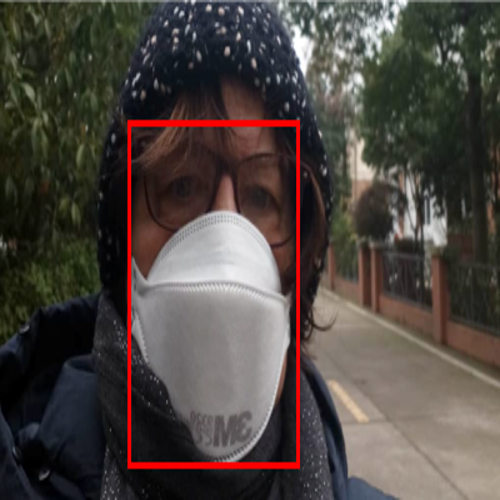

In [ ]:
from PIL import Image, ImageDraw

ds_type = "test"

with open('/content/dataset/'+ds_type+'_labels.csv' ,'r') as f:
  # filename,width,height,class,xmin,ymin,xmax,ymax
  csv_file = f.read().splitlines()[1:]

labels = {}
for csv_data in csv_file:
  filename, _, _, label, xmin,ymin,xmax, ymax = csv_data.split(',')
  if label in labels:
    labels[label]+=1
  else:
    labels[label]=1

sample_idx = np.random.randint(0, len(csv_file))
filename, _, _, label, xmin,ymin,xmax, ymax = csv_file[sample_idx].split(',')
img = Image.open('/content/dataset/'+ds_type+"/"+filename)
draw = ImageDraw.Draw(img)
draw.rectangle([(int(xmin), int(ymin)), (int(xmax), int(ymax))], width=3, outline='red')
# draw.text((int(xmin)+5, int(ymin)),label,fill='red')
print(labels)
print(label)
img.resize((500,500))

# Model path

In [ ]:
# model_path = "/content/drive/MyDrive/Checkpoints/mask_full/tflite/output_model_5676/"
model_path = "/content/drive/MyDrive/Checkpoints/mask_full/tflite/output_model_18000/"

# Prepare for testing... using the original model

In [ ]:
ls $model_path

checkpoint                            pipeline.config
frozen_inference_graph.pb             saved_model/
model.ckpt-18000.data-00000-of-00001  ssdlite_mobiledet_mask_edgetpu.log
model.ckpt-18000.index                ssdlite_mobiledet_mask_edgetpu.tflite
model.ckpt-18000.meta                 ssdlite_mobiledet_mask.tflite
model.ckpt.data-00000-of-00001        tflite_graph.pb
model.ckpt.index                      tflite_graph.pbtxt
model.ckpt.meta


In [ ]:
from PIL import Image
from PIL import ImageDraw
from IPython.display import display


def draw_bboxes(image, boxes, classes, scores, threshold=0.5, labels={1:'mask', 2: 'no_mask', 3:'poor_mask'}):
  colors = ((128, 255, 102), (102, 255, 255), (232, 123, 212))
  colors = dict(zip(labels.keys(),colors))
  image_width, image_height = image.size
  draw = ImageDraw.Draw(image)
  # Visualization of the results of a detection.
  for i in range(len(boxes)):
    if scores[i] > threshold:
      ymin = int(max(1, (boxes[i][0] * image_height)))
      xmin = int(max(1, (boxes[i][1] * image_width)))
      ymax = int(min(image_height, (boxes[i][2] * image_height)))
      xmax = int(min(image_width, (boxes[i][3] * image_width)))
      draw.rectangle((xmin, ymin, xmax, ymax), width=3, outline=colors[int(classes[i])])
      text = f'{labels[int(classes[i])]} {scores[i]*100:1.0f}%'
      draw.text((xmin+3, ymin-10), text, fill=colors[int(classes[i])], width=2)
  return image

In [ ]:
# Do a Quick Evaluation on the graph model/
import numpy as np
import os
import glob

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() # https://stackoverflow.com/a/58473143


PATH_TO_CKPT = model_path + 'frozen_inference_graph.pb'

class inference_for_single_image:
  def __init__(self, PATH_TO_CKPT):
    self.detection_graph = tf.Graph()
    with self.detection_graph.as_default():
      od_graph_def = tf.GraphDef()
      with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

    self.gen = self.__run_inference()

  def __call__(self, image, cont=True):
    next(self.gen)
    try:
      self.gen.send(cont)
    except StopIteration:
      return
    return self.gen.send(image)

  def __run_inference(self):
    with self.detection_graph.as_default():
      with tf.Session() as sess:
        # Get handles to input and output tensors
        ops = tf.get_default_graph().get_operations()
        all_tensor_names = {output.name for op in ops for output in op.outputs}
        tensor_dict = {}
        for key in ['num_detections', 'detection_boxes', 'detection_scores', 'detection_classes']:
          tensor_name = key + ':0'        
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)

        image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

        while True:
          cont = yield
          if not cont:
            break
          # Run inference
          image = yield
          output_dict = sess.run(tensor_dict, feed_dict={image_tensor: np.expand_dims(image, 0)})

          # all outputs are float32 numpy arrays, so convert types as appropriate
          output_dict['num_detections'] = int(output_dict['num_detections'][0])
          output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.uint8)
          output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
          output_dict['detection_scores'] = output_dict['detection_scores'][0]

          yield output_dict


run_inference_for_single_image = inference_for_single_image(PATH_TO_CKPT)

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
def results2cocojson(results, outputjson="/content/dataset/cocoRes.json"):
  annotations = []
  for boxes, classes, scores, (img_width, img_height), img_id in results:
    for id, (b, c, s) in enumerate(zip(boxes, classes, scores)):
      tmp_dict = {}
      tmp_dict['id'] = id
      tmp_dict['image_id'] = img_id
      x = float(b[1]*img_width)
      y = float(b[0]*img_height)
      xmax = float(b[3]*img_width)
      ymax = float(b[2]*img_height)
      w = abs(xmax-x)
      h = abs(ymax-y)
      tmp_dict['bbox'] = [x,y,w,h]
      tmp_dict['area'] = float(w*h)
      tmp_dict['category_id'] = int(c)
      tmp_dict['score'] = float(s)
      annotations.append(tmp_dict)

  # Save the annotations dictionary as a json file
  with open(outputjson, 'w') as f:
    json.dump(annotations,f,indent=2)

  # List of image_ids (necessary to calculate the averages)
  imgIds = list(set([i['image_id'] for i in annotations]))
  return imgIds

In [ ]:
PATH_TO_TEST_IMAGES_DIR = '/content/dataset/test'
# TEST_IMAGE_PATHS = [os.path.join(PATH_TO_TEST_IMAGES_DIR, fi) for fi in labels[LABEL]]
TEST_IMAGE_PATHS = list(glob.glob(PATH_TO_TEST_IMAGES_DIR + '/*.jpg'))+list(glob.glob(PATH_TO_TEST_IMAGES_DIR + '/*.png'))
# np.random.shuffle(TEST_IMAGE_PATHS)
# TEST_IMAGE_PATHS = TEST_IMAGE_PATHS[:3]

results = []
for image_path in TEST_IMAGE_PATHS:
  print('Evaluating:', image_path)
  image = Image.open(image_path)
  filename = image.filename.split('/')[-1]
  image = image.convert('RGB')
  image_id = int(filename.split('.')[0])
  img_width, img_height = image.size
  image_np = np.asarray(image)
  
  # The model has image resizing in the graph...
  # ... and the fake batch stuff is in the class already
  output_dict = run_inference_for_single_image(image_np)

  boxes, classes, scores = output_dict['detection_boxes'], output_dict['detection_classes'], output_dict['detection_scores']
  results.append((boxes, classes, scores, image.size, image_id))

  # display(draw_bboxes(image, boxes, classes, scores))

run_inference_for_single_image([], cont=False)

Evaluating: /content/dataset/test/57.png
Evaluating: /content/dataset/test/5.png
Evaluating: /content/dataset/test/41.png
Evaluating: /content/dataset/test/19.png
Evaluating: /content/dataset/test/37.png
Evaluating: /content/dataset/test/39.png
Evaluating: /content/dataset/test/46.png
Evaluating: /content/dataset/test/25.png
Evaluating: /content/dataset/test/9.png
Evaluating: /content/dataset/test/76.png
Evaluating: /content/dataset/test/12.png
Evaluating: /content/dataset/test/52.png
Evaluating: /content/dataset/test/3.png
Evaluating: /content/dataset/test/63.png
Evaluating: /content/dataset/test/84.png
Evaluating: /content/dataset/test/15.png
Evaluating: /content/dataset/test/61.png
Evaluating: /content/dataset/test/65.png
Evaluating: /content/dataset/test/64.png
Evaluating: /content/dataset/test/53.png
Evaluating: /content/dataset/test/69.png
Evaluating: /content/dataset/test/67.png
Evaluating: /content/dataset/test/26.png
Evaluating: /content/dataset/test/1.png
Evaluating: /content

In [ ]:
# Save the annotations dictionary as a json file
# returning a list of image_ids (necessary to calculate the averages)
imgIds = results2cocojson(results, "/content/dataset/cocoRes.json")

In [ ]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

cocoGt=COCO("/content/dataset/cocoGT.json")
cocoDt=cocoGt.loadRes("/content/dataset/cocoRes.json")

cocoEval = COCOeval(cocoGt,cocoDt,"bbox")
cocoEval.params.imgIds = imgIds
cocoEval.params.areaRng = [
                           [0 ** 2, 1e5 ** 2],  # all - objects that have area between 1 sq pixels and 1e10 (10_000_000_000) sq pixels
                           [0 ** 2, 32 ** 2],   # small - objects that have area between 1 sq pixels and 32^2 (1024) sq pixels
                           [32 ** 2, 96 ** 2],  # medium - objects that have area between 32^2 (1024) sq pixels and 96^2 (9216) sq pixels
                           [96 ** 2, 1e5 ** 2]  # large - objects that have area between 96^2 (9216) sq pixels and 1e10 (10_000_000_000) sq pixels
                           ]
cocoEval.params.areaRngLbl = ['all', 'small', 'medium', 'large'] # labels for areaRng
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.18s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.91s).
Accumulating evaluation results...
DONE (t=0.13s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.381
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.650
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.376
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.313
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.434
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.852
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.263
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.542
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

In [ ]:
ls $model_path

checkpoint                            pipeline.config
frozen_inference_graph.pb             saved_model/
model.ckpt-18000.data-00000-of-00001  ssdlite_mobiledet_mask_edgetpu.log
model.ckpt-18000.index                ssdlite_mobiledet_mask_edgetpu.tflite
model.ckpt-18000.meta                 ssdlite_mobiledet_mask.tflite
model.ckpt.data-00000-of-00001        tflite_graph.pb
model.ckpt.index                      tflite_graph.pbtxt
model.ckpt.meta


# Test tflite models

In [ ]:
# Now we install tflite_runtime package to evaluate the model (Python 3.7 => cp37).
!pip3 install https://github.com/google-coral/pycoral/releases/download/release-frogfish/tflite_runtime-2.5.0-cp37-cp37m-linux_x86_64.whl  

     |████████████████████████████████| 1.2MB 4.8MB/s 


In [ ]:
try:
    import tflite_runtime.interpreter as tflite
except ModuleNotFoundError:
    print("Did you install the TFLite Runtime? \
    https://github.com/ricardodeazambuja/libedgetpu-rpi0/releases/tag/rpi0_tflite_edgetpu")


EDGETPU_SHARED_LIB = 'libedgetpu.so.1'

In [ ]:
def load_model(model_file):
    if "edgetpu" in model_file:
        print("Using Edge TPU...")
        #
        # EdgeTPU Accelerator
        #
        device = [] # I have only one USB accelerator...
        tflite_interpreter = tflite.Interpreter(model_path=model_file, 
                                         experimental_delegates=[tflite.load_delegate(EDGETPU_SHARED_LIB,{'device': device[0]} if device else {})])
    else:
        print("Using CPU...")
        tflite_interpreter = tflite.Interpreter(model_path=model_file)
        
    tflite_interpreter.allocate_tensors()
    input_details = tflite_interpreter.get_input_details()
    output_details = tflite_interpreter.get_output_details()
    
    return tflite_interpreter, input_details, output_details

In [ ]:
class inference_for_single_image_tflite:
    def __init__(self, path_to_model):
        tflite_interpreter, input_details, output_details = load_model(path_to_model)
        self.interpreter = tflite_interpreter

        self.input_details = input_details
        self.output_details = output_details
        self.width = self.input_details[0]['shape'][2]
        self.height = self.input_details[0]['shape'][1]

    def __call__(self, image_np_expanded):
        self.interpreter.set_tensor(self.input_details[0]['index'], image_np_expanded)
        self.interpreter.invoke()

        return [self.interpreter.get_tensor(self.output_details[out_i]['index'])[0] for out_i in range(len(self.output_details))]

In [ ]:
from PIL import Image
from PIL import ImageDraw
from IPython.display import display

            
def process_bboxes(image, boxes, classes, scores, threshold=0.5, 
                   labels={1:'mask', 2: 'no_mask', 3:'poor_mask'},
                   crop=False):
    colors = ((128, 255, 102), (102, 255, 255), (232, 123, 212))
    colors = dict(zip(labels.keys(),colors))
    image_width, image_height = image.size

    if not crop:
        draw = ImageDraw.Draw(image)
        # Visualization of the results of a detection.
        for i in range(len(boxes)):
            if scores[i] > threshold:
                ymin = int(max(1, (boxes[i][0] * image_height)))
                xmin = int(max(1, (boxes[i][1] * image_width)))
                ymax = int(min(image_height, (boxes[i][2] * image_height)))
                xmax = int(min(image_width, (boxes[i][3] * image_width)))
                draw.rectangle((xmin, ymin, xmax, ymax), width=3, outline=colors[int(classes[i])])
                text = f'{labels[int(classes[i])]} {scores[i]*100:1.2f}%'
                draw.text((xmin+3, ymin-10), text, fill=colors[int(classes[i])], width=2)
        return image
    else:
        for i in range(len(boxes)):
            if scores[i] >= threshold:
                box = boxes[i]
                ymin = int(max(1, (boxes[i][0] * image_height)))
                xmin = int(max(1, (boxes[i][1] * image_width)))
                ymax = int(min(image_height, (boxes[i][2] * image_height)))
                xmax = int(min(image_width, (boxes[i][3] * image_width)))
                return image.crop((xmin, ymin, xmax, ymax))

In [ ]:
PATH_TO_TFLITE = model_path + 'ssdlite_mobiledet_mask.tflite'
run_inference_for_single_image_tflite_ssd = inference_for_single_image_tflite(PATH_TO_TFLITE)

Using CPU...


In [ ]:
run_inference_for_single_image_tflite_ssd.input_details

[{'dtype': numpy.uint8,
  'index': 328,
  'name': 'normalized_input_image_tensor',
  'quantization': (0.0078125, 128),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([0.0078125], dtype=float32),
   'zero_points': array([128], dtype=int32)},
  'shape': array([  1, 320, 320,   3], dtype=int32),
  'shape_signature': array([  1, 320, 320,   3], dtype=int32),
  'sparsity_parameters': {}}]

In [ ]:
# !wget --no-clobber https://images.canadagoose.com/image/upload/w_1333,c_scale,f_auto,q_auto:best/v1601577550/product-image/5558U_1073.jpg -O mask_example.jpg
# img_filename = "mask_example.jpg"
img_filename = "poor_mask_test.png"

In [ ]:
import numpy as np

image = Image.open(img_filename)
image = image.convert('RGB')
image_width, image_height = image.size

# tflite will not have the image resizing in the model
input_width = run_inference_for_single_image_tflite_ssd.width
input_height = run_inference_for_single_image_tflite_ssd.height


resized_image = image.resize((input_width, input_height))
np_image = np.asarray(resized_image)

image_np_expanded = np.expand_dims(np_image, axis=0)

# Actual detection.
boxes, classes, scores, _ = run_inference_for_single_image_tflite_ssd(image_np_expanded)

classes = [i+1 for i in classes] # class indices here start at 0

In [ ]:
classes

[3.0, 3.0, 2.0, 1.0, 1.0, 2.0, 3.0, 2.0, 1.0, 3.0]

In [ ]:
scores

array([0.640625  , 0.33984375, 0.33984375, 0.1484375 , 0.12109375,
       0.10546875, 0.09375   , 0.0859375 , 0.0859375 , 0.0859375 ],
      dtype=float32)

In [ ]:
resized_image

In [ ]:
process_bboxes(resized_image.copy(), boxes, classes, scores, threshold=0.5)

In [ ]:
# Now we do evaluation on the tflite model.
from tflite_runtime.interpreter import Interpreter
from tflite_runtime.interpreter import load_delegate

PATH_TO_TFLITE = model_path + 'ssdlite_mobiledet_mask.tflite'

class inference_for_single_image_tflite:
  def __init__(self, path_to_model):
    self.interpreter = Interpreter(path_to_model)
    self.interpreter.allocate_tensors()
    self.interpreter.invoke() # warmup

    self.input_details = self.interpreter.get_input_details()
    self.output_details = self.interpreter.get_output_details()
    self.width = self.input_details[0]['shape'][2]
    self.height = self.input_details[0]['shape'][1]

  def __call__(self, image_np_expanded):
    self.interpreter.set_tensor(self.input_details[0]['index'], image_np_expanded)
    self.interpreter.invoke()
    boxes = self.interpreter.get_tensor(self.output_details[0]['index'])[0]
    classes = self.interpreter.get_tensor(self.output_details[1]['index'])[0]
    scores = self.interpreter.get_tensor(self.output_details[2]['index'])[0]
    
    return boxes, classes, scores

run_inference_for_single_image_tflite = inference_for_single_image_tflite(PATH_TO_TFLITE)

In [ ]:
results_tflite = []
for image_path in TEST_IMAGE_PATHS:
  print('Evaluating:', image_path)
  image = Image.open(image_path)
  filename = image.filename.split('/')[-1]
  image = image.convert('RGB')
  image_id = int(filename.split('.')[0])
  image_width, image_height = image.size

  # tflite will not have the image resizing in the model
  input_width = run_inference_for_single_image_tflite.width
  input_height = run_inference_for_single_image_tflite.height
  
  if image_width!=input_width or image_height!=input_height:
    resized_image = image.resize((input_width, input_height))
    np_image = np.asarray(resized_image)
  else:
    np_image = np.asarray(image)
  
  image_np_expanded = np.expand_dims(np_image, axis=0)

  # Actual detection.
  boxes, classes, scores = run_inference_for_single_image_tflite(image_np_expanded)

  classes = [i+1 for i in classes] # class indices here start at 0

  results_tflite.append((boxes, classes, scores, image.size, image_id))


  # display(draw_bboxes(image, boxes, classes, scores, labels={1:'mask', 2: 'no_mask', 3:'poor_mask'}))

Evaluating: /content/dataset/test/57.png
Evaluating: /content/dataset/test/5.png
Evaluating: /content/dataset/test/41.png
Evaluating: /content/dataset/test/19.png
Evaluating: /content/dataset/test/37.png
Evaluating: /content/dataset/test/39.png
Evaluating: /content/dataset/test/46.png
Evaluating: /content/dataset/test/25.png
Evaluating: /content/dataset/test/9.png
Evaluating: /content/dataset/test/76.png
Evaluating: /content/dataset/test/12.png
Evaluating: /content/dataset/test/52.png
Evaluating: /content/dataset/test/3.png
Evaluating: /content/dataset/test/63.png
Evaluating: /content/dataset/test/84.png
Evaluating: /content/dataset/test/15.png
Evaluating: /content/dataset/test/61.png
Evaluating: /content/dataset/test/65.png
Evaluating: /content/dataset/test/64.png
Evaluating: /content/dataset/test/53.png
Evaluating: /content/dataset/test/69.png
Evaluating: /content/dataset/test/67.png
Evaluating: /content/dataset/test/26.png
Evaluating: /content/dataset/test/1.png
Evaluating: /content

In [ ]:
# Save the annotations dictionary as a json file
# returning a list of image_ids (necessary to calculate the averages)
imgIds = results2cocojson(results_tflite, "/content/dataset/cocoRes_tflite.json")

In [ ]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

cocoGt=COCO("/content/dataset/cocoGT.json")
cocoDt=cocoGt.loadRes("/content/dataset/cocoRes_tflite.json")

cocoEval = COCOeval(cocoGt,cocoDt,"bbox")
cocoEval.params.imgIds = imgIds
cocoEval.params.areaRng = [
                           [0 ** 2, 1e5 ** 2],  # all - objects that have area between 1 sq pixels and 1e10 (10_000_000_000) sq pixels
                           [0 ** 2, 32 ** 2],   # small - objects that have area between 1 sq pixels and 32^2 (1024) sq pixels
                           [32 ** 2, 96 ** 2],  # medium - objects that have area between 32^2 (1024) sq pixels and 96^2 (9216) sq pixels
                           [96 ** 2, 1e5 ** 2]  # large - objects that have area between 96^2 (9216) sq pixels and 1e10 (10_000_000_000) sq pixels
                           ]
cocoEval.params.areaRngLbl = ['all', 'small', 'medium', 'large'] # labels for areaRng
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.19s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.306
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.559
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.286
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.212
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.374
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.840
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.178
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.354
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

In [ ]:
!pip install git+git://github.com/ricardodeazambuja/colab_utils.git

  Cloning git://github.com/ricardodeazambuja/colab_utils.git to /tmp/pip-req-build-bd8yc30g
  Running command git clone -q git://github.com/ricardodeazambuja/colab_utils.git /tmp/pip-req-build-bd8yc30g
  Created wheel for colab-utils: filename=colab_utils-0.2-cp37-none-any.whl size=19460 sha256=fa47c6779c3187df7e269c88434b566b4f309a20af0c6d24f9ebde5a23a36d15
  Stored in directory: /tmp/pip-ephem-wheel-cache-rqgrettw/wheels/21/75/32/38aeb76b2424385f43eae9fd28c98e084308f4f6d9cb0a4f97
Successfully built colab-utils


In [ ]:
from colab_utils import webcam2numpy 
# https://github.com/ricardodeazambuja/colab_utils/blob/master/Testing_colab_utils.ipynb

In [ ]:
# Capture an image from your webcam
img_np = webcam2numpy()

In [ ]:
# we need to use PIL to more easily convert...
image = Image.fromarray(img_np)
image_width, image_height = image.size

# The model only accepts RGB (3 layers)
image = image.convert('RGB')


# tflite will not have the image resizing in the model
# so we check the model for input size
input_width = run_inference_for_single_image_tflite.width
input_height = run_inference_for_single_image_tflite.height

# resize the image
resized_image = image.resize((input_width, input_height))
# transform it into numpy array
np_image = np.asarray(resized_image)
# add the extra dimension (remember the batches...)
image_np_expanded = np.expand_dims(np_image, axis=0)

# Actual detection.
boxes, classes, scores = run_inference_for_single_image_tflite(image_np_expanded)

# Visualization of the results of a detection.
display(process_bboxes(image, boxes, classes, scores, labels={0:'mask', 1: 'no_mask', 2:'poor_mask', 3:'???'}))

In [ ]:
classes, scores

(array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 array([0.27734375, 0.27734375, 0.25      , 0.23828125, 0.2109375 ,
        0.15625   , 0.13671875, 0.13671875, 0.13671875, 0.12890625],
       dtype=float32))

Testing with images saved by the raspicam v2 and uploaded here:

In [ ]:
# we need to use PIL to more easily convert...
# image = Image.open("mask_test.png")
# image = Image.open("nomask_far_test.png")
# image = Image.open("nomask_test_colab.png")
image = Image.open("poor_mask_test.png")
image_width, image_height = image.size

# The model only accepts RGB (3 layers)
image = image.convert('RGB')


# tflite will not have the image resizing in the model
# so we check the model for input size
input_width = run_inference_for_single_image_tflite.width
input_height = run_inference_for_single_image_tflite.height

# resize the image
resized_image = image.resize((input_width, input_height))
# transform it into numpy array
np_image = np.asarray(resized_image)
# add the extra dimension (remember the batches...)
image_np_expanded = np.expand_dims(np_image, axis=0)

# Actual detection.
boxes, classes, scores = run_inference_for_single_image_tflite(image_np_expanded)

# Visualization of the results of a detection.
display(draw_bboxes(image, boxes, classes, scores, labels={0:'mask', 1: 'no_mask', 2:'poor_mask'}))

In [ ]:
scores

array([0.640625  , 0.33984375, 0.33984375, 0.1484375 , 0.12109375,
       0.10546875, 0.09375   , 0.0859375 , 0.0859375 , 0.0859375 ],
      dtype=float32)

In [ ]:
classes

array([2., 2., 1., 0., 0., 1., 2., 1., 0., 2.], dtype=float32)

In [ ]:
# we need to use PIL to more easily convert...
image = Image.open("nomask_test.png")
image_width, image_height = image.size

# The model only accepts RGB (3 layers)
image = image.convert('RGB')


# tflite will not have the image resizing in the model
# so we check the model for input size
input_width = run_inference_for_single_image_tflite.width
input_height = run_inference_for_single_image_tflite.height

# resize the image
resized_image = image.resize((input_width, input_height))
# transform it into numpy array
np_image = np.asarray(resized_image)
# add the extra dimension (remember the batches...)
image_np_expanded = np.expand_dims(np_image, axis=0)

# Actual detection.
boxes, classes, scores = run_inference_for_single_image_tflite(image_np_expanded)

# Visualization of the results of a detection.
display(draw_bboxes(image, boxes, classes, scores, labels={0:'mask', 1: 'no_mask', 2:'poor_mask'}))

In [ ]:
scores

array([0.84375   , 0.10546875, 0.1015625 , 0.09375   , 0.0859375 ,
       0.0703125 , 0.06640625, 0.06640625, 0.0625    , 0.05859375],
      dtype=float32)

In [ ]:
classes

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)